In [1]:
import pickle
import os
import sys
sys.path.insert(0, '../olympus')
sys.path.insert(0, '../graphnet/src')

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#from tqdm.auto import tqdm

import numpy as np
import seaborn as sns
import random
from jax import random
from jax import numpy as jnp

import torch
import torch_cluster
import torch_geometric
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from nemesis.event_generation.detector import make_line, generate_noise, Detector, make_triang
from nemesis.plotting import plot_event, plot_events, plot_confusion
from nemesis.data_handling.utils import event_labelling
from nemesis.node_features.feature_generation import generate_features
from nemesis.evaluation.evaluation import energy_gap_test, model_evaluation
from nemesis.evaluation.utils import count_parameters
from nemesis.models.train import train_model
from nemesis.models.gnns import Dynamic_class, DynEdge_modified

from torch.nn import Linear, Identity, ReLU, Softmax, Dropout, LeakyReLU
import torch.nn.functional as F
from torch_geometric.nn import knn_graph, TAGConv, global_mean_pool, global_max_pool, BatchNorm,  global_add_pool, EdgeConv, DynamicEdgeConv

from graphnet.models.gnn.dynedge import DynEdge
from graphnet.components.layers import DynEdgeConv
from graphnet.models.gnn.gnn import GNN
from graphnet.models.utils import calculate_xyzt_homophily, calculate_xyz_homophily_POne

%matplotlib inline


CUDA
graphnet: INFO     2022-12-25 18:22:00 - get_logger - Writing log to logs/graphnet_20221225-182200.log


INFO:graphnet:Writing log to logs/graphnet_20221225-182200.log


In [2]:
## import evaluation modules

In [3]:
outpath = "."
plt.rcParams['figure.dpi'] = 100
if torch.cuda.is_available():
    print('CUDA')
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print('CPU')
    
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50 # m
dark_noise_rate = 16 * 1e-5  # 1/ns
side_len = 100 # m
pmts_per_module = 16
pmt_cath_area_r = 75E-3 / 2 # m
module_radius = 0.21 # m

efficiency = pmts_per_module * (pmt_cath_area_r)**2 * np.pi / (4*np.pi*module_radius**2)
det = make_triang(side_len, oms_per_line, dist_z, dark_noise_rate, rng, efficiency=efficiency)
module_positions = jnp.asarray(det.module_coords)

CUDA


In [ ]:
cascades, cascade_records = pickle.load(open(os.path.join(outpath, f"events/cascades.pickle"), "rb"))
tracks, track_records = pickle.load(open(os.path.join(outpath, f"events/tracks.pickle"), "rb"))
stracks, strack_records = pickle.load(open(os.path.join(outpath, f"events/stracks.pickle"), "rb"))

In [5]:
#cascades1, cascade_records1 = pickle.load(open(f"/dss/pone/pone_events/cascades_15000ev_3.5-6.5.pickle", "rb"))
#print('cascades DONE!')
#tracks1, track_records1 = pickle.load(open(f"/dss/pone/pone_events/tracks_15000ev_3.5-6.5.pickle", "rb"))
#print('tracks DONE!')
#stracks1, strack_records1 = pickle.load(open(f"/dss/pone/pone_events/stracks_15000ev_3.5-6.5.pickle", "rb"))
#print('starting tracks DONE!')
#cascades2, cascade_records2 = pickle.load(open(f"/dss/pone/pone_events/cascades_15000ev_3.5-6.5_2.pickle", "rb"))
#print('cascades DONE!')
#tracks2, track_records2 = pickle.load(open(f"/dss/pone/pone_events/tracks_15000ev_3.5-6.5_2.pickle", "rb"))
#print('tracks DONE!')
#stracks2, strack_records2 = pickle.load(open(f"/dss/pone/pone_events/stracks_15000ev_3.5-6.5_2.pickle", "rb"))
#print('starting tracks DONE!')
#
#cascades = cascades1 + cascades2
#cascade_records = cascade_records1 + cascade_records2
#tracks = tracks1 + tracks2
#track_records = track_records1 + track_records2
#stracks = stracks1 + stracks2
#strack_records = strack_records1 + strack_records2

In [6]:
cascade_labels, track_labels, strack_labels = event_labelling(track_records, strack_records, cascade_records, det_hull=(75.0, 1000.0))

all_events = cascades + tracks + stracks
all_records = cascade_records + track_records + strack_records
all_labels = cascade_labels + track_labels + strack_labels
print(len(all_events), len(all_records), len(all_labels))

1500 1500 1500


In [7]:
data_array = generate_features(det, all_events, all_labels)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [8]:
#pickle.dump(data_array, open("/dss/pone/pone_events/features_arrays/data_array_90k_k8_R75.pickle", "wb"))
#data_array = pickle.load(open("/dss/pone/pone_events/features_arrays/data_array_90k_k8_R75.pickle", "rb"))

In [9]:
import random
random.seed(234567)

indices = np.arange(len(data_array))
random.shuffle(indices)


shuffled_data = [data_array[i] for i in indices]
split_test = int(len(shuffled_data)*0.9)
training_data = shuffled_data[:split_test]
split_val = int(len(training_data)*0.9)
train_dataset = training_data[:split_val]
val_dataset = training_data[split_val:]

test_dataset = shuffled_data[split_test:]
test_indices = indices[split_test:]

In [10]:
#epochs = 200
#num_classes=4
#patience = 200
#batch_size = 200
#learning_rates = [0.001]
#use_writer = False
#print_step = 1
#k = 8
#schedulers = ['ReduceLROnPlateau']#, 'CosineAnnealingLR', 'OneCycleLR', 'MultiStepLR']
label_map = {0:"Contained cascade", 1:'Throughgoing Track', 2:"Starts in detector", 3:"Rest of events"}
#best_acc, patience_count = 0, 0
#all_trains_acc, all_vals_acc, all_trains_loss, all_vals_loss = [], [], [], []
#num_node_features=15


In [4]:

#model = Dynamic_class(out_channels=num_classes, k=k)
model = DynEdge_modified(15, 4, k = 8, features_subset = slice(12, 15), layer_size_scale=2)
model.to(device)
#count_parameters(model)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/lightning.py:22: LightningDeprecationWarning: pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.core.module.LightningModule class instead.
  rank_zero_deprecation(


DynEdge_modified(
  (conv_add1): DynEdgeConv(nn=Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  ))
  (conv_add2): DynEdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  ))
  (conv_add3): DynEdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  ))
  (conv_cat1): DynEdgeConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negativ

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 000, Train Acc: 0.3860, Val Acc: 0.4370, patience: 0
Epoch: 001, Train Acc: 0.4354, Val Acc: 0.4370, patience: 1
Epoch: 002, Train Acc: 0.4658, Val Acc: 0.5111, patience: 2
Epoch: 003, Train Acc: 0.5202, Val Acc: 0.5630, patience: 1
Epoch: 004, Train Acc: 0.4996, Val Acc: 0.4889, patience: 1
Epoch: 005, Train Acc: 0.5671, Val Acc: 0.6222, patience: 2
Epoch: 006, Train Acc: 0.5844, Val Acc: 0.5704, patience: 1
Epoch: 007, Train Acc: 0.5926, Val Acc: 0.6296, patience: 2
Epoch: 008, Train Acc: 0.6041, Val Acc: 0.5778, patience: 1
Epoch: 009, Train Acc: 0.6000, Val Acc: 0.6074, patience: 2
Epoch: 010, Train Acc: 0.6222, Val Acc: 0.5630, patience: 3
Epoch: 011, Train Acc: 0.6206, Val Acc: 0.6370, patience: 4
Epoch: 012, Train Acc: 0.6329, Val Acc: 0.6148, patience: 1
Epoch: 013, Train Acc: 0.6403, Val Acc: 0.6074, patience: 2
Epoch: 014, Train Acc: 0.6486, Val Acc: 0.5852, patience: 3
Epoch: 015, Train Acc: 0.6650, Val Acc: 0.6222, patience: 4
Epoch: 016, Train Acc: 0.6560, Val Acc: 

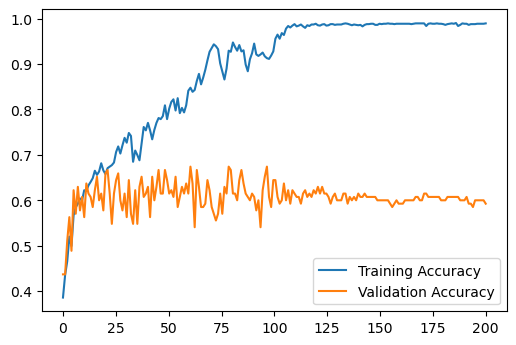

In [13]:
model, all_trains_acc, all_vals_acc = train_model(model, train_dataset, val_dataset, label_map, k=8, epochs=200, patience=200, print_step=1)
plt.plot(np.linspace(0, len(all_trains_acc), len(all_trains_acc)), all_trains_acc, label="Training Accuracy")
plt.plot(np.linspace(0, len(all_vals_acc), len(all_vals_acc)), all_vals_acc, label="Validation Accuracy")
plt.legend()
plt.show()


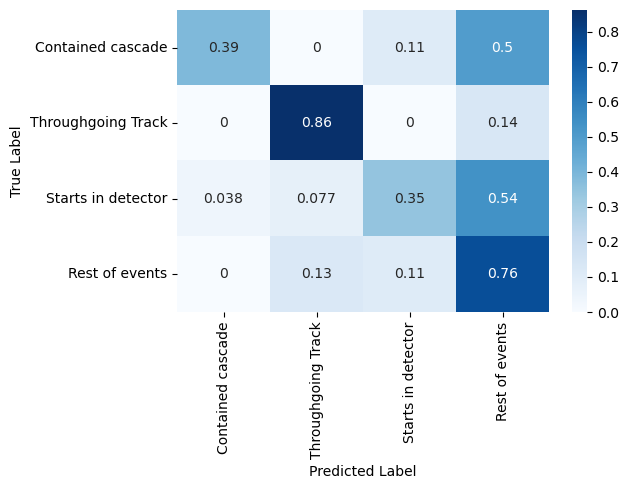

The test accuracy achieved is:  68.0


In [14]:
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)
fig1, miss_idx1, test_acc=model_evaluation(model, test_loader, all_events, all_records, all_labels, label_map, test_indices)
print('The test accuracy achieved is: ', test_acc)

In [5]:
model = torch.load(os.path.join(outpath, "saved_models/model_test.pt"))
#torch.save(model, os.path.join(outpath, "saved_models/model_test.pt"))

In [6]:
cascades_test, cascade_records_test = pickle.load(open(os.path.join(outpath, "events/500test_cascades_all.pickle"), "rb"))
tracks_test, track_records_test = pickle.load(open(os.path.join(outpath, "events/500test_tracks_all.pickle"), "rb"))
stracks_test, strack_records_test = pickle.load(open(os.path.join(outpath, "events/500test_stracks_all.pickle"), "rb"))

In [7]:
cascade_labels_test, track_labels_test, strack_labels_test = event_labelling(track_records_test, strack_records_test, cascade_records_test, det_hull=[75, 1100])
all_events_test = cascades_test + tracks_test + stracks_test
all_records_test = cascade_records_test + track_records_test + strack_records_test
all_labels_test = cascade_labels_test + track_labels_test + strack_labels_test

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

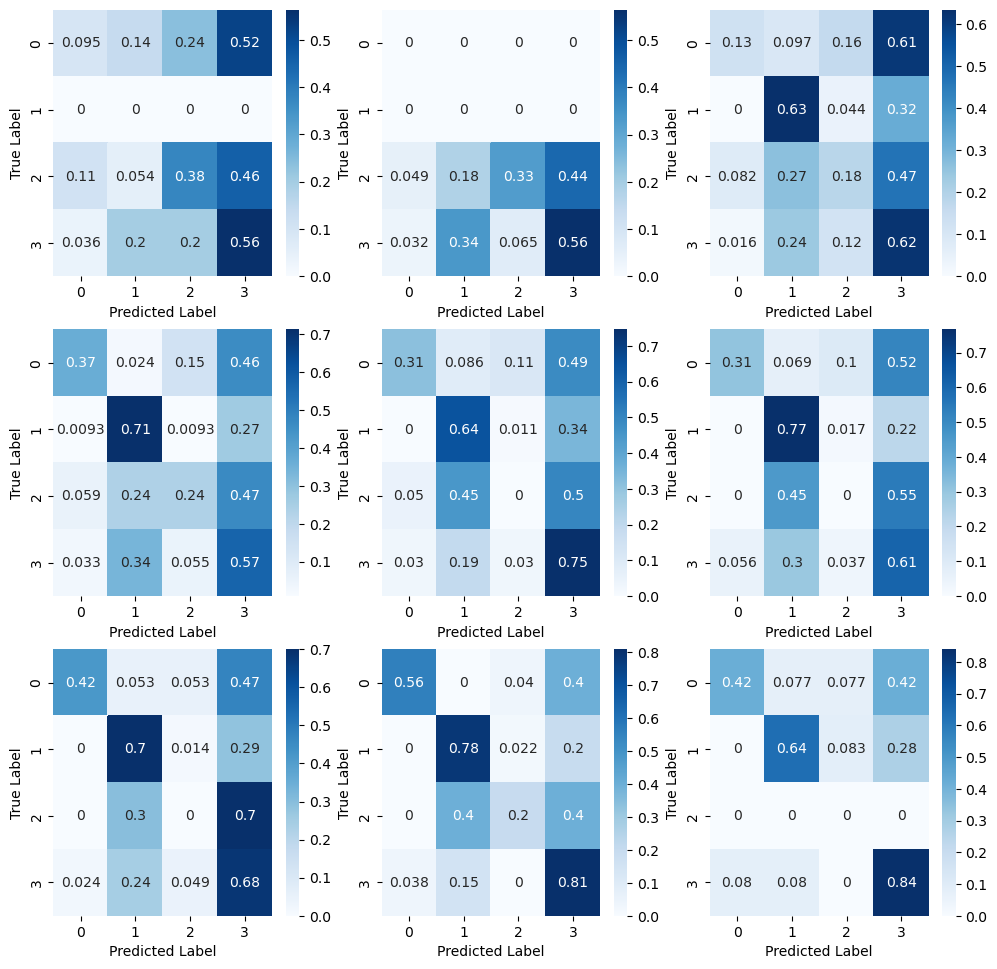

The accuracies of the different energy divisions are [41.5929203539823, 44.71544715447155, 50.0, 55.47445255474452, 56.132075471698116, 57.142857142857146, 60.714285714285715, 70.58823529411765, 63.2183908045977]


In [8]:
gaps_to_evaluate = energy_gap_test(det, model, all_events_test, all_records_test, all_labels_test, num_divisions=10, k=8)
energy_divisions = gaps_to_evaluate.energy_division_loaders()
fig, test_accuracies, misscls_idx = gaps_to_evaluate.energy_evaluation()